<a href="https://colab.research.google.com/github/explainpark101/2025-2-DL/blob/main/reinforced_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Environment of Blackjack

In [1]:
!pip install "gymnasium>=1.2.2"

In [2]:
from dataclasses import dataclass
from gymnasium.envs.toy_text.blackjack import BlackjackEnv as InfiniteDeckBlackjackEnv

@dataclass
class BlackJackRewards:
    BUST: float = -5.0
    LOSS: float = -3.0
    WIN: float = 3.0
    NATURAL_BLACKJACK: float = 4.5
    DRAW: float = 0.0

class BlackjackEnv(InfiniteDeckBlackjackEnv):
    def __init__(self, render_mode=None, num_decks=6, rewards: BlackJackRewards = BlackJackRewards(), natural=True, sab=False):
        # 부모 클래스 초기화 (기본 설정 유지)
        super().__init__(render_mode=render_mode, sab=sab, natural=natural)

        self.num_decks = num_decks
        self.deck = []
        self.reshuffle_deck()

        self.rewards = rewards

    def reshuffle_deck(self):
        # 1~13 (A~K) 카드를 4무늬 * N덱 만큼 생성
        # Gymnasium Blackjack은 J,Q,K를 모두 10으로 처리하므로 그에 맞춰 구성
        # 1(Ace), 2~9, 10(10,J,Q,K) 비율 반영
        deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4 * self.num_decks
        self.np_random.shuffle(deck)
        self.deck = deck

    def step(self, action):
        next_state, original_reward, terminated, truncated, info = super().step(action)

        final_reward = original_reward

        # 게임이 끝난 경우(terminated)에만 보상 수정 로직 적용
        if terminated or truncated:
            if action == 1: # 상황 1: Hit(1)을 했는데 게임이 끝남 -> 무조건 Bust
                final_reward = self.rewards.BUST

            elif action == 0: # 상황 2, 3, 4: Stay(0)를 해서 게임이 끝남 -> 결과 비교
                if original_reward == 1.5: # natural blackjack
                    final_reward = self.rewards.NATURAL_BLACKJACK
                elif original_reward > 0:
                    final_reward = self.rewards.WIN
                elif original_reward < 0:
                    final_reward = self.rewards.LOSS
                else:
                    final_reward = self.rewards.DRAW

        return next_state, final_reward, terminated, truncated, info

    def draw_card(self):
        if len(self.deck) < 1: # 댁 다 쓰면 다음 라운드
            self.reshuffle_deck()
        return self.deck.pop()

    def reset(self, seed=None, options=None):
        # 덱 초기화가 필요하면 여기서 처리
        return super().reset(seed=seed, options=options)

# Create Neural Network and Replay Buffer Class

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from tqdm.notebook import tqdm

In [4]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        # Input: Player Sum, Dealer Card, Usable Ace (3 dim)
        self.fc = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2) # Output: Stay(0), Hit(1)
        )

    def forward(self, x):
        return self.fc(x)

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

In [6]:
class DDQNAgent:
    def __init__(self, device):
        self.device = device
        self.policy_net = QNetwork().to(device)
        self.target_net = QNetwork().to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)
        self.memory = ReplayBuffer(10000)

        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def preprocess(self, state):
        # Tuple State (Sum, Dealer) -> Tensor
        # Ace는 boolean이므로 float으로 변환
        state_arr = np.array([state[0], state[1], state[2]], dtype=np.float32)
        return torch.FloatTensor(state_arr).unsqueeze(0).to(self.device)

    def act(self, state):
        if random.random() < self.epsilon:
            return random.choice([0, 1])
        else:
            with torch.no_grad():
                state_t = self.preprocess(state)
                q_values = self.policy_net(state_t)
                return torch.argmax(q_values).item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return 0.0
        states: tuple[int, int]
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert to Tensor
        states = torch.FloatTensor(np.array([
            [s[0], s[1], s[2]] for s in states
        ])).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array([
            [ns[0], ns[1], ns[2]] for ns in next_states
        ])).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # DDQN Logic
        # 1. Main Net에서 다음 상태의 최적 행동 선택 (argmax)
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1).unsqueeze(1)
            # 2. Target Net에서 그 행동의 Q값 계산
            next_q_values = self.target_net(next_states).gather(1, next_actions)
            # 3. Target 값 계산
            target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # Current Q
        current_q_values = self.policy_net(states).gather(1, actions)

        # Compute Loss & Update
        loss = nn.MSELoss()(current_q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Learning

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rewards = BlackJackRewards(
    BUST = -5.0,
    LOSS = -3.0,
    WIN = 3.0,
    NATURAL_BLACKJACK = 3.5,
    DRAW = 0.0
)
env = BlackjackEnv(num_decks=6, rewards=rewards, natural=True, sab=True)
agent = DDQNAgent(device)

num_episodes = 50_000
target_update_freq = 100


recent_rewards = deque(maxlen=100)
recent_losses = deque(maxlen=100)

# progress bar | not for learning, but for visualization of learning
pbar = tqdm(range(num_episodes), desc="Training", unit="ep", mininterval=1.0)


Training:   0%|          | 0/50000 [00:00<?, ?ep/s]

In [8]:
def train(pbar):
    for episode in pbar:
        state, _ = env.reset()
        done = False
        total_reward = 0
        loss = 0

        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            loss = agent.train()

        # Update params
        agent.update_epsilon()
        if episode % target_update_freq == 0:
            agent.update_target_net()

        # Logging
        recent_rewards.append(total_reward)
        if loss != 0: recent_losses.append(loss)

        avg_reward = np.mean(recent_rewards) if recent_rewards else 0.0
        avg_loss = np.mean(recent_losses) if recent_losses else 0.0

        # tqdm bar update
        if episode % 300 == 0:
            pbar.set_postfix({
                'Avg Reward': f'{avg_reward:.2f}',
                'Loss': f'{avg_loss:.4f}',
                'Eps': f'{agent.epsilon:.2f}'
            })
# train()

## Model Save

In [9]:
# torch.save(agent.policy_net.state_dict(), "ddqn_blackjack.pth")

# Test

In [10]:
import torch
import numpy as np

# --- 1. Load Model & Environment ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QNetwork().to(device)

try:
    model.load_state_dict(torch.load("ddqn_blackjack.pth"))
except FileNotFoundError:
    print("모델 파일이 없습니다. 학습을 먼저 진행해주세요.")
    exit()

model.eval() # 평가 모드 (Dropout/BatchNorm 등 비활성화)
env = BlackjackEnv(num_decks=6, rewards=rewards)

# --- 2. Helper Function for Inference ---
def get_ai_action(state, model=model):
    # State: (PlayerSum, DealerShow, UsableAce)
    state_arr = np.array([state[0], state[1], state[2]], dtype=np.float32)
    state_t = torch.FloatTensor(state_arr).unsqueeze(0).to(device)

    with torch.no_grad():
        q_values = model(state_t)
        return torch.argmax(q_values).item() # 0: Stay, 1: Hit

# --- 3. Testing Loop ---
def test_play(num_games=10, print_result=False, model=model, rewards=rewards):
    env = BlackjackEnv(num_decks=6, rewards=rewards)
    wins = 0
    draws = 0
    losses = 0
    if not print_result:
        def print(*args, **kwargs):
            pass
    print(f"\n--- AI 상세 테스트 시작 ({num_games} 게임) ---")

    for i in range(num_games):
        state, _ = env.reset()
        done = False
        print(f"\n[Game {i+1}]")

        # Player Turn
        while not done:
            player_sum, dealer_show, usable_ace = state

            # --- 수정된 부분: 현재 패 정보를 env 객체에서 직접 가져옴 ---
            current_player_hand = env.player  # 예: [10, 5]

            action = get_ai_action(state, model)
            action_str = "Hit" if action == 1 else "Stay"

            print(f"  Turn: Player {current_player_hand} ({player_sum}) vs Dealer Show [{dealer_show}] -> Action: {action_str}")

            if action == 0: # Stay
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
            else: # Hit
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

            state = next_state

        # --- Game Over: 최종 결과 및 딜러의 숨겨진 패 공개 ---
        card_map = {
            1: 'A',
            11: 'J',
            12: 'Q',
            13: "K",
            **{i:i for i in range(2, 11)}
        }
        final_player_hand = env.player
        final_dealer_hand = env.dealer # 게임이 끝나면 딜러의 모든 카드가 공개됨
        final_player_hand_show = list(card_map.get(card) for card in env.player)
        final_dealer_hand_show = list(card_map.get(card) for card in env.dealer) # 게임이 끝나면 딜러의 모든 카드가 공개됨

        # 승패 판정 로직
        if reward == rewards.NATURAL_BLACKJACK or reward == rewards.WIN:
            result = "WIN"
            wins += 1
        elif reward == rewards.LOSS or reward == rewards.BUST:
            result = "LOSS"
            losses += 1
        elif reward == rewards.DRAW:
            result = "DRAW"
            draws += 1
        else:
            raise ValueError(f"Invalid reward: {reward}")

        print(f"  Result: {result} (Reward: {reward})")
        print(f"  >> Final Hands: Player {final_player_hand_show} ({sum(final_player_hand)}) vs Dealer {final_dealer_hand_show} ({sum(final_dealer_hand)})")

    # --- Final Stats ---
    print("\n" + "="*30)
    print(f"총 전적: {wins}승 {draws}무 {losses}패")
    print(f"승률: {wins/num_games*100:.1f}% (무승부 포함 {(wins+draws)/num_games*100:.1f}%)")
    print("="*30)
    return wins, losses, draws, num_games
def test_main(model, rewards, test_play_count=10000):
    strategy_datas = [test_play(test_play_count, print_result=False, model=model, rewards=rewards) for i in range(30)]

    # print(f"{total_days}테이블 동안의 승률: {np.mean(win_rates)*100:.1f}%")
    # print(f"최고 승률: {max(win_rates)*100:.1f}%")
    # print(f"최저 승률: {min(win_rates)*100:.1f}%")
    return strategy_datas


if __name__ == "__main__":
    pass
    # main()

모델 파일이 없습니다. 학습을 먼저 진행해주세요.


# Startegy Heatmap

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Load Model ---
# (QNetwork 클래스가 정의되어 있어야 함)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QNetwork().to(device)
def main():
    try:
        model.load_state_dict(torch.load("ddqn_blackjack.pth"))
        model.eval()
    except FileNotFoundError:
        print("모델 파일이 없습니다.")
        exit()

    def get_best_action(player_sum, dealer_card, usable_ace):
        # Model Input: [PlayerSum, DealerCard, UsableAce]
        state = torch.FloatTensor([player_sum, dealer_card, int(usable_ace)]).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state)
            return torch.argmax(q_values).item() # 0: Stay, 1: Hit

    # --- 2. Generate Strategy Grids ---
    # Dealer Card: 1(Ace) ~ 10
    dealer_cards = range(1, 11)
    dealer_labels = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    # Hard Hand: Player Sum 4 ~ 21 (Ace 없음 or Ace=1)
    hard_sums = range(21, 3, -1) # 21부터 4까지 역순 (그래프 위쪽이 높은 숫자)
    hard_grid = []

    for p_sum in hard_sums:
        row = []
        for d_card in dealer_cards:
            action = get_best_action(p_sum, d_card, usable_ace=False)
            row.append(action)
        hard_grid.append(row)

    # Soft Hand: Player Sum 12 ~ 21 (Usable Ace 존재)
    soft_sums = range(21, 11, -1)
    soft_grid = []

    for p_sum in soft_sums:
        row = []
        for d_card in dealer_cards:
            action = get_best_action(p_sum, d_card, usable_ace=True)
            row.append(action)
        soft_grid.append(row)

    # --- 3. Plot Heatmaps ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Helper to plot
    def plot_strategy(ax, grid, y_labels, title):
        sns.heatmap(grid, cmap="coolwarm_r", annot=True, fmt="d", cbar=False,
                    xticklabels=dealer_labels, yticklabels=y_labels,
                    linewidths=.5, ax=ax)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel("Dealer Show Card")
        ax.set_ylabel("Player Sum")
        # 0(Red/Stay), 1(Blue/Hit)

    plot_strategy(axes[0], hard_grid, hard_sums, "Hard Hand Strategy (No Usable Ace)")
    plot_strategy(axes[1], soft_grid, soft_sums, "Soft Hand Strategy (Usable Ace)")

    # Legend 추가
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3b4cc0', label='Hit (1)'),
                    Patch(facecolor='#b40426', label='Stay (0)')]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if __name__ == "__main__":
    pass
    # main()

Training:   0%|          | 0/50000 [00:00<?, ?ep/s]

디스코드 전송 성공!


Training:   0%|          | 0/50000 [00:00<?, ?ep/s]

디스코드 전송 성공!


Training:   0%|          | 0/50000 [00:00<?, ?ep/s]

디스코드 전송 성공!


Training:   0%|          | 0/50000 [00:00<?, ?ep/s]

디스코드 전송 성공!


Training:   0%|          | 0/50000 [00:00<?, ?ep/s]

디스코드 전송 성공!


<Response [204]>

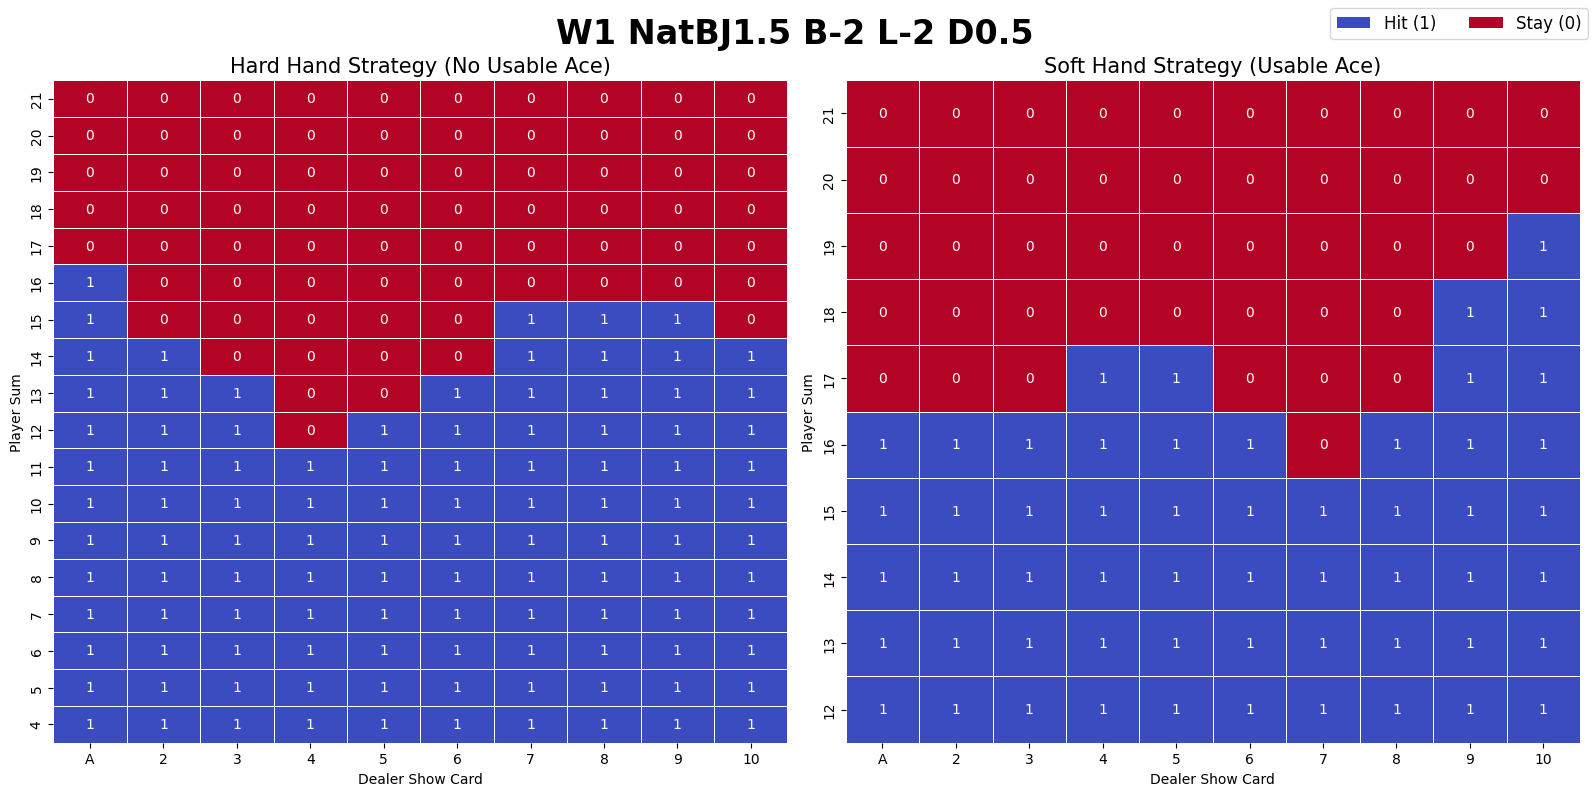

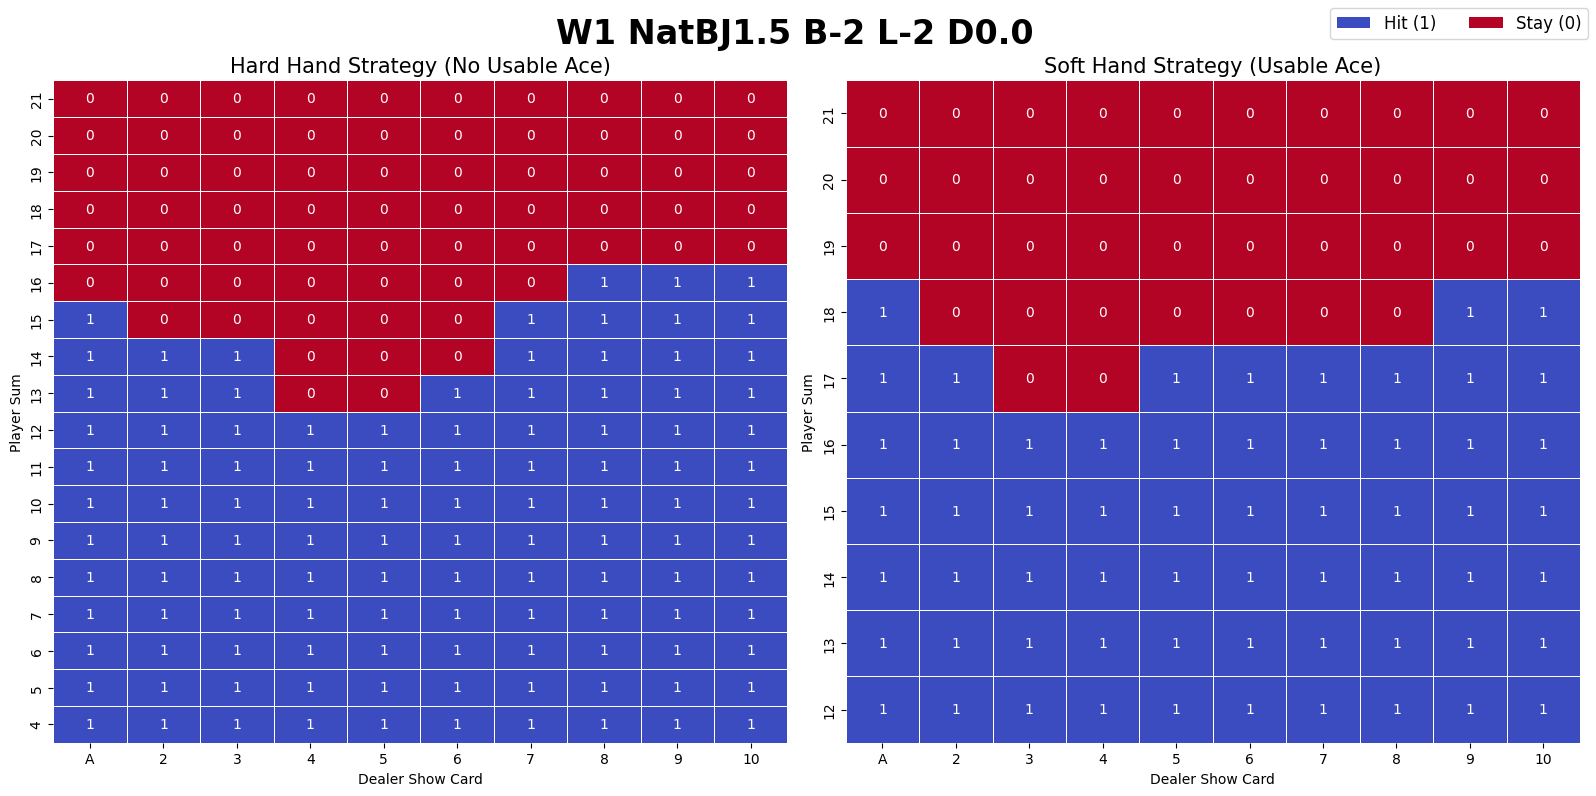

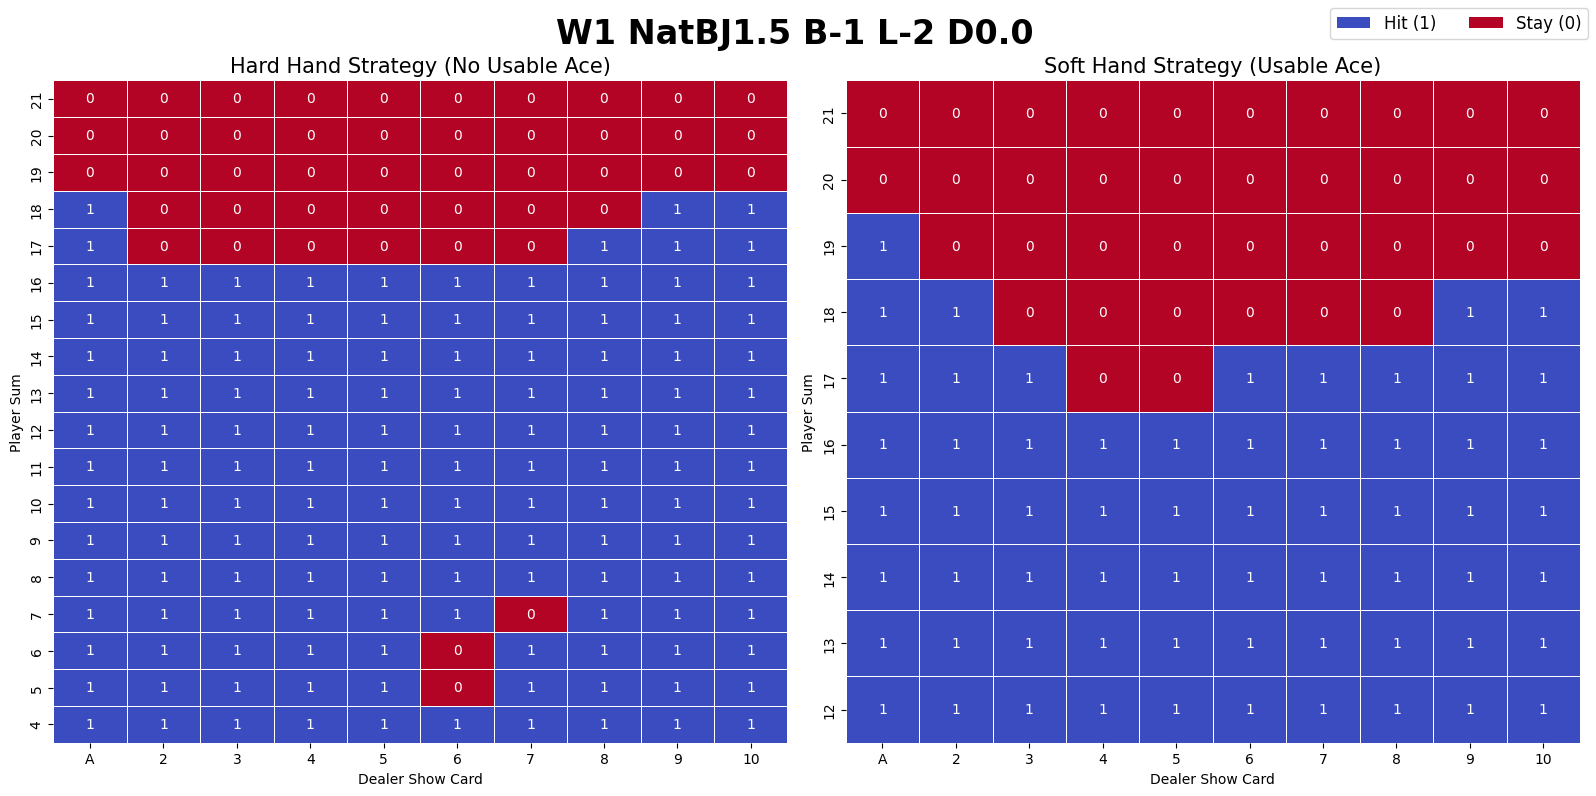

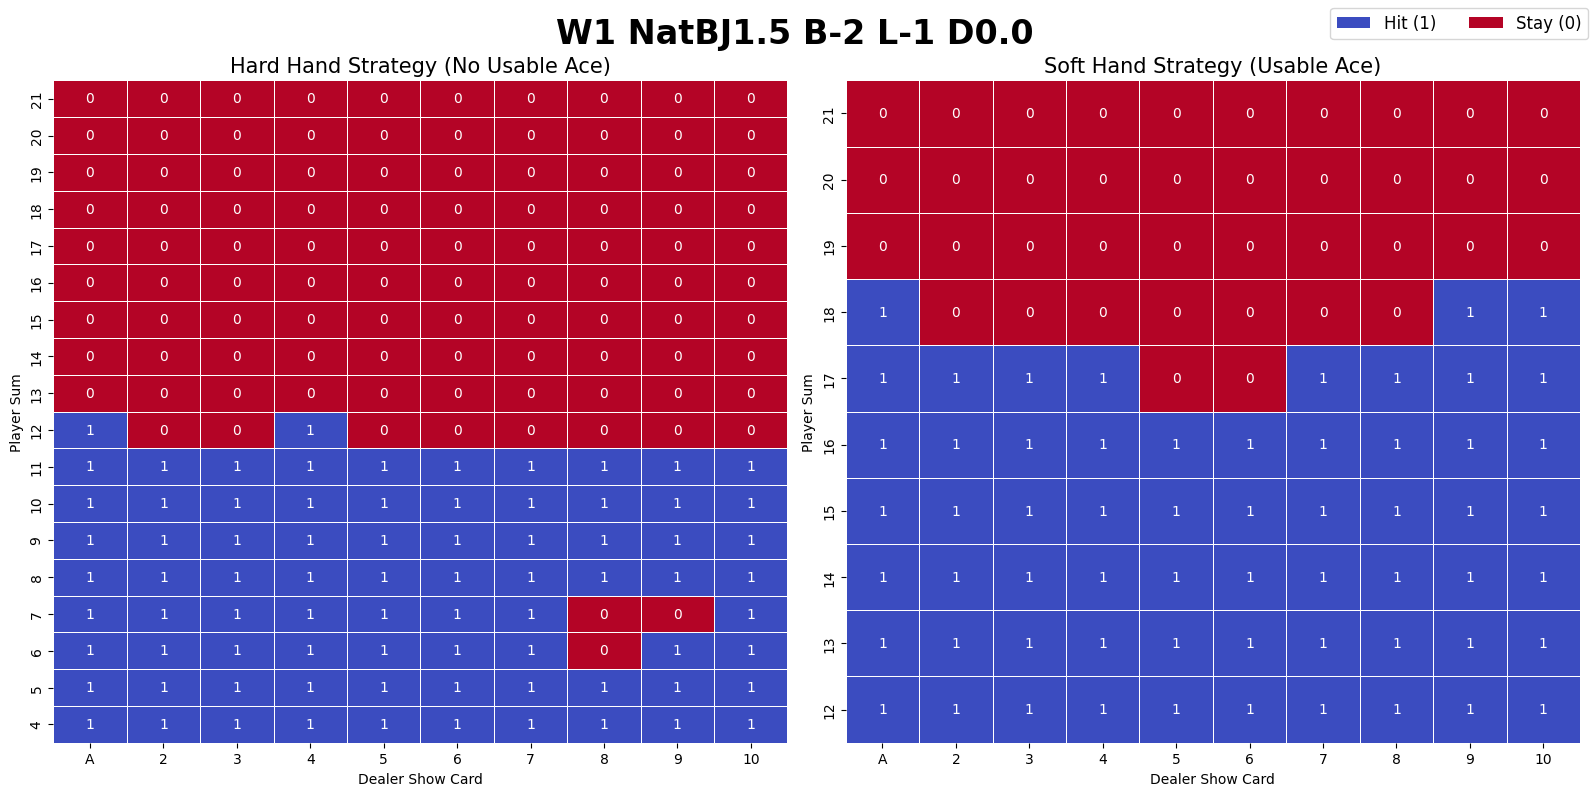

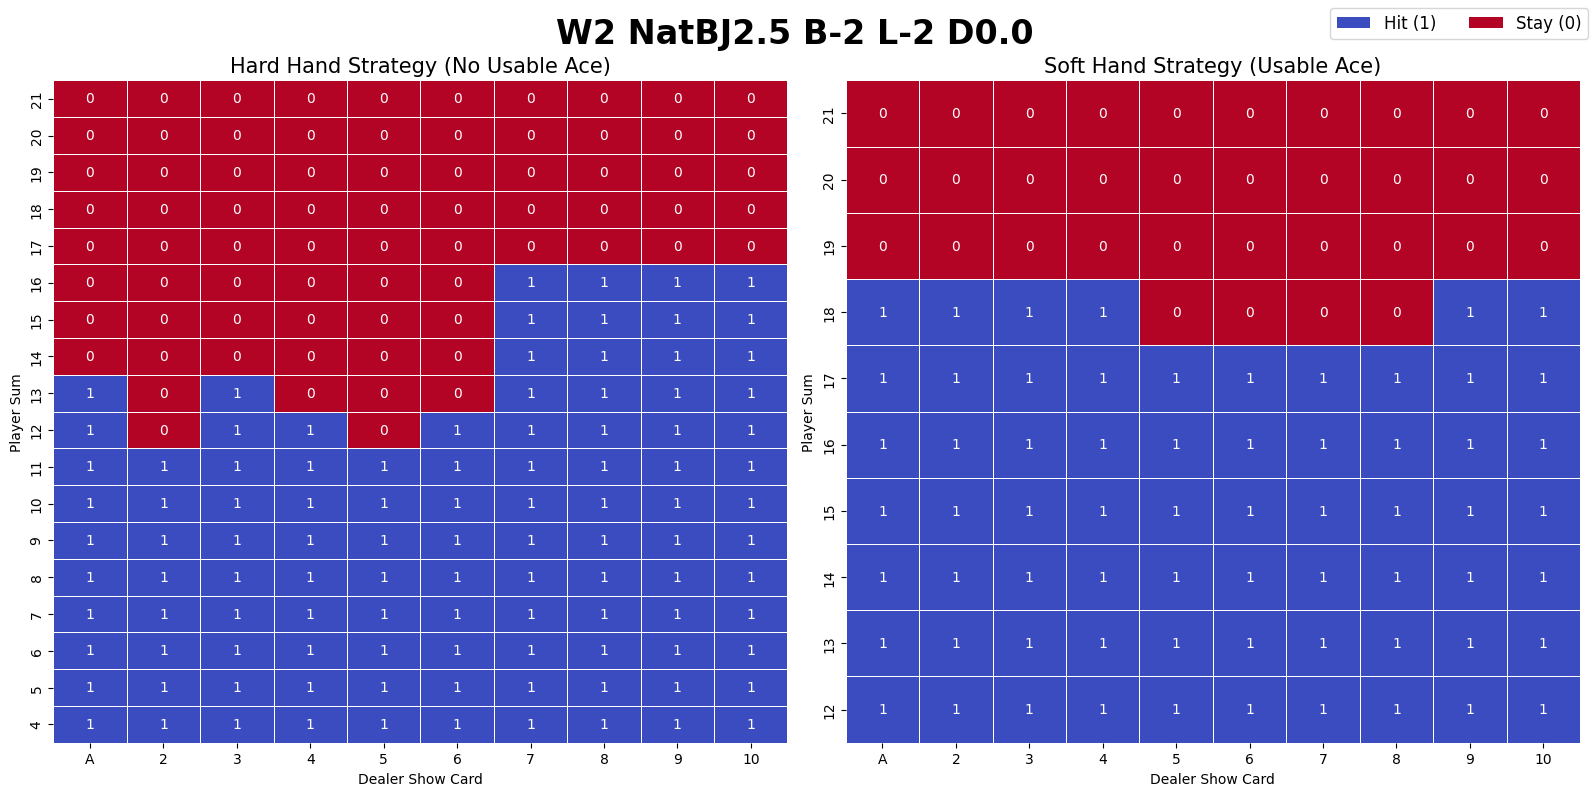

In [12]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import sys

DISCORD_WEBHOOK_URL = ""
assert DISCORD_WEBHOOK_URL.strip() != ""

def send_current_plot_to_discord(filename="plot.png", message="학습 그래프 전송"):
    """
    현재 plt에 그려진 그림을 메모리 버퍼에 저장 후 디스코드 웹훅으로 전송
    """
    # 1. 메모리 버퍼 생성
    buf = io.BytesIO()

    # 2. 그래프를 버퍼에 저장 (파일 생성 X)
    plt.savefig(buf, format='png', bbox_inches='tight')

    # 3. 파일 포인터를 맨 앞으로 이동 (필수)
    buf.seek(0)

    # 4. 디스코드 전송 (Multipart/form-data)
    files = {
        'file': (filename, buf, 'image/png')
    }
    data = {
        "content": message
    }


    try:
        response = requests.post(DISCORD_WEBHOOK_URL, data=data, files=files)
        if response.status_code == 200 or response.status_code == 204:
            print("디스코드 전송 성공!")
        else:
            print(f"디스코드 전송 실패: {response.status_code} - {response.text}")
    except Exception as e:
        print(f"전송 중 에러 발생: {e}")
    finally:
        # 5. 버퍼 닫기
        buf.close()
# env.rewards 별로 학습이 된 그래프 비교하기

device = "cuda" if torch.cuda.is_available() else "cpu"
agent = DDQNAgent(device)

num_episodes = 50_000
target_update_freq = 100


recent_rewards = deque(maxlen=100)
recent_losses = deque(maxlen=100)

# progress bar | not for learning, but for visualization of learning

step = .5
reward_diff_range = np.arange(-5, 5+step, step)
rewards_set = [
    BlackJackRewards(
        BUST = -2,
        LOSS = -2,
        WIN = 1,
        NATURAL_BLACKJACK = 1.5,
        DRAW = 0.5
    ),
    BlackJackRewards(
        BUST = -2,
        LOSS = -2,
        WIN = 1,
        NATURAL_BLACKJACK = 1.5,
        DRAW = 0.0
    ),
    BlackJackRewards(
        BUST = -1,
        LOSS = -2,
        WIN = 1,
        NATURAL_BLACKJACK = 1.5,
        DRAW = 0.0
    ),
    BlackJackRewards(
        BUST = -2,
        LOSS = -1,
        WIN = 1,
        NATURAL_BLACKJACK = 1.5,
        DRAW = 0.0
    ),
    BlackJackRewards(
        BUST = -2,
        LOSS = -2,
        WIN = 2,
        NATURAL_BLACKJACK = 2.5,
        DRAW = 0.0
    ),
]
win_data = []
for rewards in rewards_set:
    env = BlackjackEnv(num_decks=6, rewards=rewards, natural=True, sab=True)
    pbar = tqdm(range(num_episodes), desc="Training", unit="ep")
    train(pbar)
    weight = agent.policy_net.state_dict()


    # --- 1. Load Model ---
    # (QNetwork 클래스가 정의되어 있어야 함)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = QNetwork().to(device)

    try:
        model.load_state_dict(weight)

        model.eval()
    except FileNotFoundError:
        print("모델 파일이 없습니다.")
        exit()

    def get_best_action(player_sum, dealer_card, usable_ace):
        # Model Input: [PlayerSum, DealerCard, UsableAce]
        state = torch.FloatTensor([player_sum, dealer_card, int(usable_ace)]).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state)
            return torch.argmax(q_values).item() # 0: Stay, 1: Hit

    # --- 2. Generate Strategy Grids ---
    # Dealer Card: 1(Ace) ~ 10
    dealer_cards = range(1, 11)
    dealer_labels = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10']

    # Hard Hand: Player Sum 4 ~ 21 (Ace 없음 or Ace=1)
    hard_sums = range(21, 3, -1) # 21부터 4까지 역순 (그래프 위쪽이 높은 숫자)
    hard_grid = []

    for p_sum in hard_sums:
        row = []
        for d_card in dealer_cards:
            action = get_best_action(p_sum, d_card, usable_ace=False)
            row.append(action)
        hard_grid.append(row)

    # Soft Hand: Player Sum 12 ~ 21 (Usable Ace 존재)
    soft_sums = range(21, 11, -1)
    soft_grid = []

    for p_sum in soft_sums:
        row = []
        for d_card in dealer_cards:
            action = get_best_action(p_sum, d_card, usable_ace=True)
            row.append(action)
        soft_grid.append(row)

    # --- 3. Plot Heatmaps ---
    reward_title = f"W{rewards.WIN} NatBJ{rewards.NATURAL_BLACKJACK} B{rewards.BUST} L{rewards.LOSS} D{rewards.DRAW}"
    win_rates = test_main(model, rewards, test_play_count=10000)
    win_rates = f"{np.mean([w/t for (w, l, d, t) in win_rates])}±{np.std([w/t for (w, l, d, t) in win_rates])}%"

    for d in win_rates:
        win_data.append([reward_title, *d])


    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Helper to plot
    def plot_strategy(ax, grid, y_labels, title):
        sns.heatmap(grid, cmap="coolwarm_r", annot=True, fmt="d", cbar=False,
                    xticklabels=dealer_labels, yticklabels=y_labels,
                    linewidths=.5, ax=ax)
        ax.set_title(title, fontsize=15)
        ax.set_xlabel("Dealer Show Card")
        ax.set_ylabel("Player Sum")
        # 0(Red/Stay), 1(Blue/Hit)

    plot_strategy(axes[0], hard_grid, hard_sums, "Hard Hand Strategy (No Usable Ace)")
    plot_strategy(axes[1], soft_grid, soft_sums, "Soft Hand Strategy (Usable Ace)")

    # Legend 추가
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#3b4cc0', label='Hit (1)'),
                    Patch(facecolor='#b40426', label='Stay (0)')]
    fig.legend(handles=legend_elements, loc='upper right', ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # title 추가
    fig.suptitle(reward_title, fontsize=24, fontweight='bold', y=0.98)

    send_current_plot_to_discord(f"ddqn_blackjack_{reward_title.replace(" ", "")}.png", f"""weight 상태:
```
bust: {rewards.BUST}
loss: {rewards.LOSS}
natural_blackjack: {rewards.NATURAL_BLACKJACK}
win: {rewards.WIN}
draw: {rewards.DRAW}
win_rate: {win_rates}
```
""")
    # plt.show()
requests.post(DISCORD_WEBHOOK_URL, data={
        "content": "학습 끝끝"
    })



In [1]:
win_data

NameError: name 'win_data' is not defined

In [13]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import glm

columns = ['Strategy', 'Run', 'Wins', 'Losses', 'Draws', 'Total_Games']
df = pd.DataFrame(win_data, columns=columns)

# 분석을 위한 추가 변수 생성
# 1. Non_Wins: 승리가 아닌 모든 결과 (Losses + Draws)
df['Non_Wins'] = df['Losses'] + df['Draws']
# 2. Total_Events: 총 시도 횟수 (Total_Games와 동일)
df['Total_Events'] = df['Total_Games']

# DataFrame의 첫 5행 출력 및 정보 확인
print("--- 1. DataFrame 생성 결과 (상위 5행) ---")
print(df.head())
print(f"\n총 데이터 포인트 수: {len(df)} (5 전략 x 30 반복)")


# --- 3. 통계 분석: 이항 GLM (승리 확률 비교) ---

# 가설: 다섯 전략의 승리 확률은 동일하다. (H0)
# 모델: Wins (성공) 대 Non_Wins (실패) 비율을 비교하는 로지스틱 회귀 (Binomial GLM)

print("\n--- 2. 이항 GLM (승리 대 비승리) 분석 결과 ---")
# C(Strategy)는 Strategy를 범주형 변수로 사용함을 명시합니다.
# 'Wins + Non_Wins' 구문은 GLM에 성공 횟수와 실패 횟수를 제공하는 표준 방식입니다.
model_binomial = glm(
    'Wins + Non_Wins ~ C(Strategy)',
    data=df,
    family=sm.families.Binomial()
).fit()

print(model_binomial.summary())

# Odds Ratio (오즈비) 계산: 해석을 돕기 위해
print("\n--- 3. Odds Ratio (오즈비) (전략 A 대비) ---")
odds_ratios = np.exp(model_binomial.params)
print(odds_ratios)

# --- 4. 통계적 결론 ---
p_value_threshold = 0.05

print(f"\n--- 4. 최종 결론 ($\alpha={p_value_threshold}$) ---")

# P-value가 0.05 미만인 계수만 확인 (Intercept 제외)
significant_params = model_binomial.pvalues[1:][model_binomial.pvalues[1:] < p_value_threshold]

if significant_params.empty:
    print("모든 전략 간 P-value가 0.05보다 커서, 전략 A 대비 다른 전략들의 승리 확률에 통계적으로 유의미한 차이가 있다고 결론 내릴 수 없습니다. (귀무가설 기각 실패)")
else:
    print(f"전략 A 대비 승리 확률에 유의미한 차이를 보이는 전략:")
    print(significant_params)

print("\n*참고: 무승부(Draw) 결과를 포함한 다항 로지스틱 회귀 분석은 데이터 구조를 더 복잡하게 변환해야 하며, 위의 결과는 '승리'와 '비승리'만을 비교한 것입니다.")

ValueError: 6 columns passed, passed data had 2 columns